In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import fisher_exact
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier
import pickle

In [2]:
combined_flights_2022 = pd.read_parquet("../data/extracted/extracted_flight_2022.parquet")
combined_flights_2021 = pd.read_parquet("../data/extracted/extracted_flight_2021.parquet")
combined_flights_2020 = pd.read_parquet("../data/extracted/extracted_flight_2020.parquet")
combined_flights_2019 = pd.read_parquet("../data/extracted/extracted_flight_2019.parquet")
combined_flights_2018 = pd.read_parquet("../data/extracted/extracted_flight_2018.parquet")

In [3]:
pattern_2018 = combined_flights_2018[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2019 = combined_flights_2019[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2020 = combined_flights_2020[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2021 = combined_flights_2021[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2022 = combined_flights_2022[["FlightDate","Airline", "Month", "DayOfWeek"]]

In [4]:
combined_pattern = pd.concat([pattern_2018, pattern_2019, pattern_2020, pattern_2021, pattern_2022])

In [5]:
counts_by_month = combined_pattern.groupby('Month').count()

In [6]:
counts_by_month = counts_by_month.reset_index()

counts_by_month.rename(columns={'index': 'Month'}, inplace=True)


Text(0.5, 1.0, 'Number of flights per Month from 2018-2022')

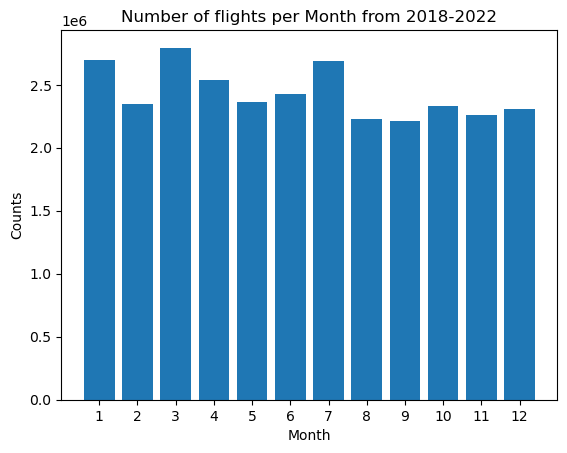

In [7]:
plt.bar(counts_by_month["Month"], counts_by_month["FlightDate"])
plt.xticks(ticks=counts_by_month["Month"], labels=counts_by_month["Month"])
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("Number of flights per Month from 2018-2022")

In [8]:
counts_by_week = combined_pattern.groupby('DayOfWeek').count()
counts_by_week = counts_by_week.reset_index()

Text(0.5, 1.0, 'Number of flights per Day of the Week from 2018-2022')

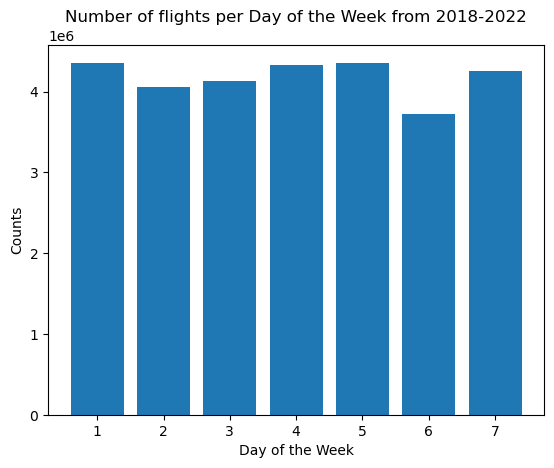

In [9]:
plt.bar(counts_by_week["DayOfWeek"], counts_by_week["FlightDate"])
plt.xlabel("Day of the Week")
plt.ylabel("Counts")
plt.title("Number of flights per Day of the Week from 2018-2022")

In [10]:
combined_flights_2018['total delay'] = combined_flights_2018['DepDelayMinutes'] + combined_flights_2018['ArrDelayMinutes']
combined_flights_2019['total delay'] = combined_flights_2019['DepDelayMinutes']+ combined_flights_2019['ArrDelayMinutes']
combined_flights_2020['total delay'] = combined_flights_2020['DepDelayMinutes']+ combined_flights_2020['ArrDelayMinutes']
combined_flights_2021['total delay'] = combined_flights_2021['DepDelayMinutes']+ combined_flights_2021['ArrDelayMinutes']
combined_flights_2022['total delay'] = combined_flights_2022['DepDelayMinutes']+ combined_flights_2022['ArrDelayMinutes']

In [11]:
delay_config_2018 = combined_flights_2018[["FlightDate","Airline","total delay"]]
delay_config_2019 = combined_flights_2019[["FlightDate","Airline","total delay"]]
delay_config_2020 = combined_flights_2020[["FlightDate","Airline","total delay"]]
delay_config_2021 = combined_flights_2021[["FlightDate","Airline","total delay"]]
delay_config_2022 = combined_flights_2022[["FlightDate","Airline","total delay"]]

In [12]:
combined_delay = pd.concat([delay_config_2018, delay_config_2019, delay_config_2020, delay_config_2021, delay_config_2022])

In [13]:
airline_counts = combined_delay.groupby('Airline').count()
airline_counts = airline_counts.reset_index()

Text(0.5, 1.0, 'Number of flights per Airline from 2018-2022')

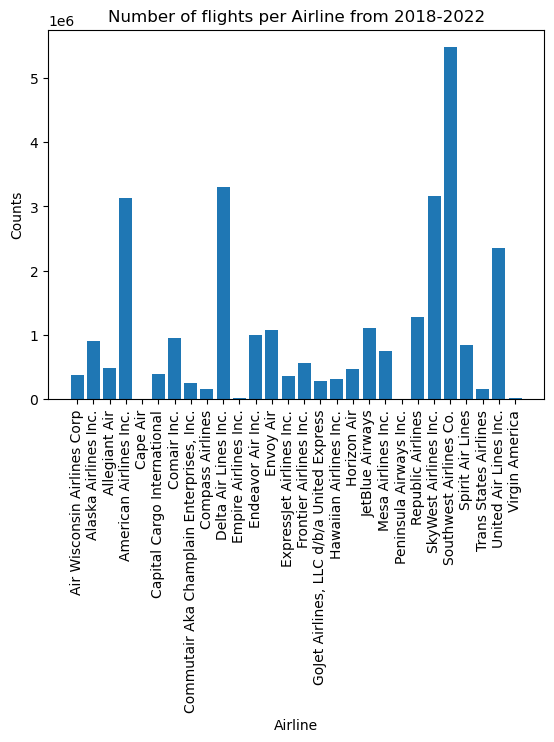

In [14]:
plt.bar(airline_counts["Airline"], airline_counts["FlightDate"])
plt.xlabel("Airline")
plt.xticks(rotation = 90)
plt.ylabel("Counts")
plt.title("Number of flights per Airline from 2018-2022")

In [15]:
combined_delay["count"] = combined_delay["Airline"].map(combined_delay["Airline"].value_counts())
combined_delay["normalized_count"] = (combined_delay["count"] - combined_delay["count"].min()) / (combined_delay["count"].max() - combined_delay["count"].min())
combined_delay

,FlightDate,Airline,total delay,count,normalized_count
0,2018-01-23,Endeavor Air Inc.,0.0,998224,0.182098
1,2018-01-24,Endeavor Air Inc.,0.0,998224,0.182098
2,2018-01-25,Endeavor Air Inc.,0.0,998224,0.182098
3,2018-01-26,Endeavor Air Inc.,0.0,998224,0.182098
4,2018-01-27,Endeavor Air Inc.,0.0,998224,0.182098
...,...,...,...,...,...
590537,2022-03-31,Republic Airlines,NaN,1283704,0.234262
590538,2022-03-17,Republic Airlines,NaN,1283704,0.234262
590539,2022-03-08,Republic Airlines,759.0,1283704,0.234262
590540,2022-03-25,Republic Airlines,NaN,1283704,0.234262


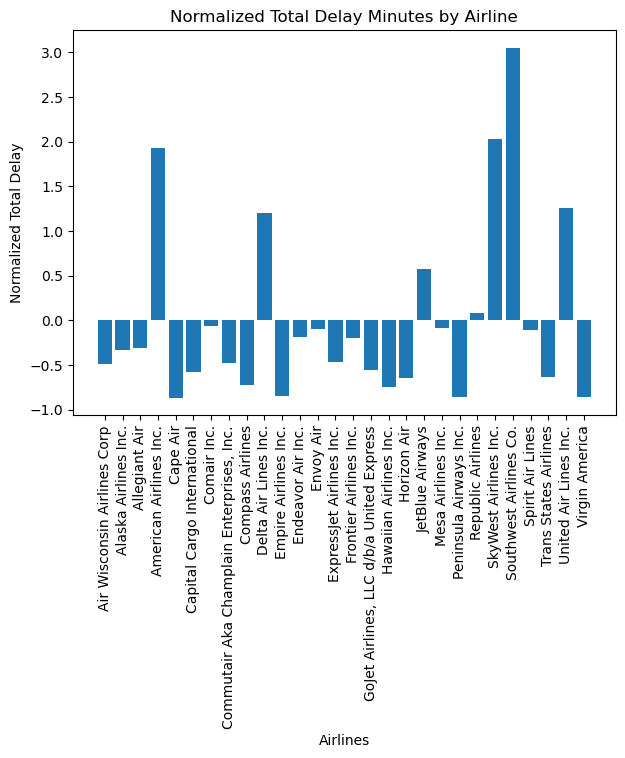

In [16]:
airline_delays = combined_delay.groupby("Airline").sum(numeric_only=True)[["total delay", "normalized_count"]].reset_index()

airline_delays["normalized_total_delay"] = (airline_delays["total delay"] - airline_delays["total delay"].mean()) / \
                                           airline_delays["total delay"].std()
plt.figure(figsize=(7, 5))
plt.bar(airline_delays["Airline"], airline_delays["normalized_total_delay"])


plt.xlabel("Airlines")
plt.ylabel("Normalized Total Delay")
plt.xticks(rotation =90)
plt.title("Normalized Total Delay Minutes by Airline")

plt.show()

In [17]:
#Fisher's Exact Test 

#get flightdate, cancelled, diverted 
binary_2018 = combined_flights_2018[["FlightDate","Cancelled", "Diverted"]]
binary_2019 = combined_flights_2019[["FlightDate","Cancelled", "Diverted"]]
binary_2020 = combined_flights_2020[["FlightDate","Cancelled", "Diverted"]]
binary_2021 = combined_flights_2021[["FlightDate","Cancelled", "Diverted"]]
binary_2022 = combined_flights_2022[["FlightDate","Cancelled", "Diverted"]]
#concat 
binary_all = pd.concat([binary_2018, binary_2019, binary_2020, binary_2021, binary_2022])
#make contingency table 
contingency_table = pd.crosstab(binary_all['Cancelled'], binary_all['Diverted'])
#set hypothesis
#H0 = cancelled and diverted are not independent 
#Ha cancelled and diverted are indepeneent 
#perform test
odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")


Odds Ratio: 0.0010672506426181979
P-value: 0.0


In [18]:
contingency_table

Diverted,False,True
Cancelled,,
False,28348168,68347
True,777265,2


In [19]:
#since pvalue is less than 0.05, there is evidence to conclude that there is significant association between cancelled and diverted 

In [20]:
# add flight delays bar plots
flightdelay_2018 = combined_flights_2018[(combined_flights_2018["DepDelay"] > 0) | (combined_flights_2018["ArrDelay"] > 0)
][["FlightDate", "Airline", "Month", "DayOfWeek","DepDelay", "ArrDelay"]]
flightdelay_2019 = combined_flights_2019[(combined_flights_2019["DepDelay"] > 0) | (combined_flights_2019["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
flightdelay_2020 = combined_flights_2020[(combined_flights_2020["DepDelay"] > 0) | (combined_flights_2020["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
flightdelay_2021 = combined_flights_2021[(combined_flights_2021["DepDelay"] > 0) | (combined_flights_2021["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
flightdelay_2022 = combined_flights_2022[(combined_flights_2022["DepDelay"] > 0) | (combined_flights_2022["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
 

In [21]:
combined_delays = pd.concat([flightdelay_2018, flightdelay_2019, flightdelay_2020, flightdelay_2021, flightdelay_2022])

In [22]:
delays_by_month = combined_delays.groupby('Month').count()
delays_by_month = delays_by_month.reset_index()

Text(0.5, 1.0, 'Number of flight delays per Month from 2018-2022')

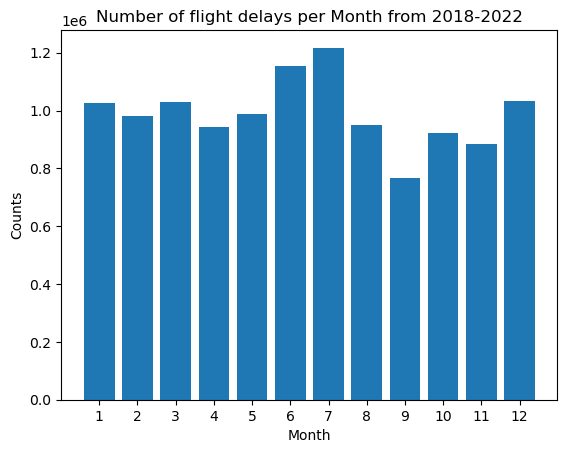

In [23]:
plt.bar(delays_by_month["Month"], delays_by_month["FlightDate"])
plt.xticks(ticks=delays_by_month["Month"], labels=delays_by_month["Month"])
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("Number of flight delays per Month from 2018-2022")

In [24]:
delays_by_week = combined_delays.groupby('DayOfWeek').count()
delays_by_week = delays_by_week.reset_index()

Text(0.5, 1.0, 'Number of flight delays per Day of Week from 2018-2022')

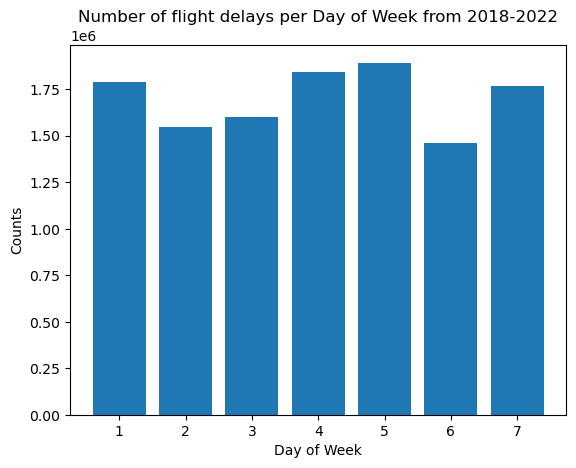

In [25]:
plt.bar(delays_by_week["DayOfWeek"], delays_by_week["FlightDate"])
plt.xticks(ticks=delays_by_week["DayOfWeek"], labels=delays_by_week["DayOfWeek"])
plt.xlabel("Day of Week")
plt.ylabel("Counts")
plt.title("Number of flight delays per Day of Week from 2018-2022")

In [6]:
data_2019 = df[df['FlightDate'].dt.year == 2019]

,FlightDate,DayOfWeek,Month,Airline,Origin,Dest,Cancelled,Diverted,DivAirportLandings,CRSDepTime,...,Origin_PRCP,Origin_SNOW,Origin_SNWD,Origin_TMAX,Origin_TMIN,Dest_PRCP,Dest_SNOW,Dest_SNWD,Dest_TMAX,Dest_TMIN
5647643,2019-04-11,4,4,United Air Lines Inc.,SFO,IAH,False,False,0.0,940,...,0.0,0.0,0.0,150.0,100.0,10.0,0.0,0.0,261.0,178.0
5647644,2019-04-11,4,4,United Air Lines Inc.,LAS,IAH,False,False,0.0,1355,...,0.0,0.0,0.0,217.0,133.0,10.0,0.0,0.0,261.0,178.0
5647645,2019-04-11,4,4,United Air Lines Inc.,LGA,ORD,False,False,0.0,1000,...,0.0,0.0,0.0,111.0,44.0,71.0,0.0,0.0,133.0,28.0
5647646,2019-04-11,4,4,United Air Lines Inc.,ORD,CMH,False,False,0.0,1445,...,71.0,0.0,0.0,133.0,28.0,0.0,0.0,0.0,278.0,56.0
5647647,2019-04-11,4,4,United Air Lines Inc.,CMH,DEN,False,False,0.0,708,...,0.0,0.0,0.0,278.0,56.0,13.0,8.0,80.0,17.0,-82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13637814,2019-01-16,3,1,Mesa Airlines Inc.,DFW,LBB,False,False,0.0,849,...,0.0,0.0,0.0,178.0,56.0,NaN,NaN,NaN,NaN,NaN
13637815,2019-01-17,4,1,Mesa Airlines Inc.,DFW,LBB,False,False,0.0,849,...,0.0,0.0,0.0,144.0,50.0,NaN,NaN,NaN,NaN,NaN
13637816,2019-01-16,3,1,Mesa Airlines Inc.,DFW,MSN,False,False,0.0,1025,...,0.0,0.0,0.0,178.0,56.0,NaN,NaN,NaN,NaN,NaN
13637817,2019-01-26,6,1,Mesa Airlines Inc.,DFW,LBB,False,False,0.0,849,...,0.0,0.0,0.0,139.0,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
data_2019.rename(columns={'Origin': 'origin_col', 'Dest': 'dest_col'}, inplace=True)

avg_snowfall = data_2019.groupby(['FlightDate', 'origin_col', 'dest_col']).agg(
    avg_origin_snow=('Origin_SNOW', 'mean'),
    avg_dest_snow=('Dest_SNOW', 'mean'))
avg_snowfall = avg_snowfall.reset_index()


/var/folders/n_/w242b7zx2sd87hlvjw747wh80000gn/T/ipykernel_7523/2319995607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019.rename(columns={'Origin': 'origin_col', 'Dest': 'dest_col'}, inplace=True)


In [14]:
avg_snowfall

,FlightDate,origin_col,dest_col,avg_origin_snow,avg_dest_snow
0,2019-01-01,ABE,ATL,0.0,0.0
1,2019-01-01,ABE,CLT,0.0,0.0
2,2019-01-01,ABE,DTW,0.0,0.0
3,2019-01-01,ABE,ORD,0.0,3.0
4,2019-01-01,ABE,PHL,0.0,NaN
...,...,...,...,...,...
1842627,2019-12-31,YAK,CDV,0.0,0.0
1842628,2019-12-31,YAK,JNU,0.0,NaN
1842629,2019-12-31,YKM,SEA,0.0,0.0
1842630,2019-12-31,YUM,DFW,NaN,0.0


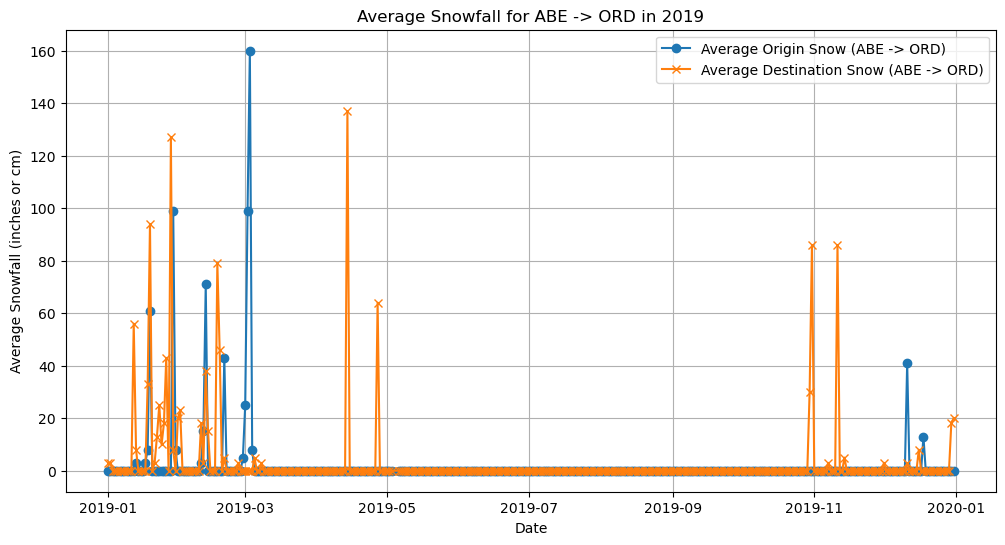

In [ ]:

subset = avg_snowfall[(avg_snowfall['origin_col'] == 'ABE') & (avg_snowfall['dest_col'] == 'ORD')]

plt.figure(figsize=(12, 6))
plt.plot(subset['FlightDate'], subset['avg_origin_snow'], label='Average Origin Snow (ABE -> ORD)', marker='o')
plt.plot(subset['FlightDate'], subset['avg_dest_snow'], label='Average Destination Snow (ABE -> ORD)', marker='x')

plt.title('Average Snowfall for ABE -> ORD in 2019')
plt.xlabel('Date')
plt.ylabel('Average Snowfall (inches or cm)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
X_train = pd.read_parquet("../data/final/X_train_enc.parquet")
X_test = pd.read_parquet("../data/final/X_test_enc.parquet")
y_train = pd.read_parquet("../data/final/y_train.parquet")
y_test = pd.read_parquet("../data/final/y_test.parquet")

In [5]:
columns_drop = ["FlightDate", "DelayCategory", "AirTimeCategory","TimeofDay"]
X_train = X_train.drop(columns_drop, axis =1 )
X_test = X_test.drop(columns_drop, axis=1)

In [6]:
X_train = X_train.dropna()
y_train_clean = y_train.loc[X_train.index]  # Keep only corresponding y values
X_test = X_test.dropna()
y_test_clean = y_test.loc[X_test.index]

In [7]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train_clean)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [20]:
with open("logreg.pkl", "wb") as file:
    pickle.dump(model, file)

In [21]:
with open("logreg.pkl", "rb") as file:
    logreg_model = pickle.load(file)

In [19]:
y_pred = logreg_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test_clean, y_pred))
print("Classification Report:\n", classification_report(y_test_clean, y_pred))
print("Accuracy:", accuracy_score(y_test_clean, y_pred))

Confusion Matrix:
 [[553222   7216]
 [  2937 567398]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    560438
         1.0       0.99      0.99      0.99    570335

    accuracy                           0.99   1130773
   macro avg       0.99      0.99      0.99   1130773
weighted avg       0.99      0.99      0.99   1130773

Accuracy: 0.9910211863919637


In [9]:
sgd_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000, random_state=42)

In [10]:
sgd_clf.fit(X_train, y_train_clean)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(loss='log_loss', random_state=42)

In [22]:
with open("sgd.pkl", "wb") as file:
    pickle.dump(sgd_clf, file)

In [23]:
with open("sgd.pkl", "rb") as file:
    sgd_model = pickle.load(file)

In [24]:
y_pred = sgd_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test_clean, y_pred))
print("Accuracy:", accuracy_score(y_test_clean, y_pred))
print(classification_report(y_test_clean, y_pred))

Confusion Matrix:
 [[560416     22]
 [     2 570333]]
Accuracy: 0.9999787755809522
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    560438
         1.0       1.00      1.00      1.00    570335

    accuracy                           1.00   1130773
   macro avg       1.00      1.00      1.00   1130773
weighted avg       1.00      1.00      1.00   1130773



In [12]:
#to do: 1. hyperparatmeter tuning 2. feature imporantance 